# Trump Speech Analysis for 2025 SOTU Predictions

This notebook analyzes the frequency of specific phrases to predict their occurrence in the 2025 SOTU address using:
1. Regular speeches (from /speech directory)
2. Previous State of the Union addresses (from /sotu directory)

In [1]:
import os
import re
from datetime import datetime
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('default')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [12, 6]

In [2]:
# Define the phrases to search for
SEARCH_PHRASES = {
    'Immigration': r'\b(illegal\s+immigra(nt|nts|nt\'s|nts\')|immigration)\b',
    'America First': r'\b(america\s+first)\b',
    'America': r'\b(america|america\'s)\b', 
    'Border': r'\b(border|borders|border\'s|borders\')\b',
    'DOGE': r'\b(doge|doge\'s|department\s+of\s+government\s+efficiency)\b',
    'AI': r'\b(ai|ai\'s|artificial\s+intelligence|artificial\s+intelligence\'s)\b',
    'Ceasefire': r'\b(ceasefire|ceasefires|ceasefire\'s|ceasefires\')\b',
    'Middle Class': r'\b(middle\s+class|middle\s+class\'s|middle\s+classes|middle\s+classes\')\b',
    'God': r'\b(god|god\'s|gods|gods\')\b',
    'Elon': r'\b(elon|elon\'s|elon\s+musk|elon\s+musk\'s)\b',
    'Drill Baby Drill': r'\bdrill\s+baby\s+drill\b',
    'Biden': r'\b(biden|biden\'s)\b',
    'Make America Healthy Again': r'\bmake\s+america\s+healthy\s+again\b',
    'LA': r'\b(la|la\'s|los\s+angeles|los\s+angeles\')\b',
    'January 6': r'\b(january\s+6(th)?|january\s+sixth)\b',
    'TikTok': r'\b(tiktok|tiktok\'s)\b',
    'Crypto': r'\b(crypto|crypto\'s|cryptos|bitcoin|bitcoin\'s)\b',
    'MAGA': r'\b(maga|maga\'s|make\s+america\s+great\s+again)\b',
    'Trans': r'\b(trans|trans\')\b',
    'Kamala': r'\b(kamala|kamala\'s)\b',
    'Rigged': r'\b(rig(ged)?)\b',
    'Mandate': r'\b(mandate|mandates|mandate\'s|mandates\')\b',
    'Carnage': r'\b(carnage|carnage\'s)\b'
}

In [3]:
def count_phrases(text, phrases=SEARCH_PHRASES):
    """Count occurrences of phrases in text"""
    counts = {}
    for name, pattern in phrases.items():
        counts[name] = len(re.findall(pattern, text.lower()))
    return counts

def get_date_from_filename(filename):
    """Extract date from filename format YYYY-MM-DD_..."""
    date_str = filename.split('_')[0]
    return datetime.strptime(date_str, '%Y-%m-%d')

def read_transcript(filepath):
    """Read and return transcript text"""
    with open(filepath, 'r', encoding='utf-8') as f:
        return f.read()

def process_directory(directory):
    """Process transcripts from speech and sotu directories only"""
    results = []
    categories_found = set()
    
    for root, _, files in os.walk(directory):
        category = os.path.basename(root)
        categories_found.add(category)
        
        if category in ['speech', 'sotu']:
            for file in files:
                if file.endswith('.txt'):
                    filepath = os.path.join(root, file)
                    try:
                        date = get_date_from_filename(file)
                        text = read_transcript(filepath)
                        counts = count_phrases(text)
                        
                        results.append({
                            'date': date,
                            'file': file,
                            'category': category,
                            'text_length': len(text.split()),
                            **counts
                        })
                    except Exception as e:
                        print(f"Error processing {filepath}: {str(e)}")
    
    print("Categories found in directory:")
    for cat in sorted(categories_found):
        print(f"- {cat}")
    print("\nOnly 'speech' and 'sotu' categories will be analyzed.\n")
    
    return pd.DataFrame(results)

In [4]:
# Process transcripts
df = process_directory('../data/processed-transcripts')
df = df.sort_values('date')

# Split into speeches and SOTU
df_speeches = df[df['category'] == 'speech']
df_sotu = df[df['category'] == 'sotu']

# Print dataset statistics
print("Dataset Statistics:")
print(f"Regular speeches: {len(df_speeches)}")
print(f"SOTU addresses: {len(df_sotu)}")

print("\nWord Count Statistics:")
print(f"Regular speeches average length: {df_speeches['text_length'].mean():.0f} words")
print(f"Regular speeches total words: {df_speeches['text_length'].sum():,} words")
print(f"SOTU average length: {df_sotu['text_length'].mean():.0f} words")
print(f"SOTU total words: {df_sotu['text_length'].sum():,} words")

print("\nDate Ranges:")
print(f"Regular speeches: {df_speeches['date'].min().strftime('%Y-%m-%d')} to {df_speeches['date'].max().strftime('%Y-%m-%d')}")
print(f"SOTU addresses: {df_sotu['date'].min().strftime('%Y-%m-%d')} to {df_sotu['date'].max().strftime('%Y-%m-%d')}")

Categories found in directory:
- interview
- press conference
- press gaggle
- processed-transcripts
- remarks
- sotu
- speech

Only 'speech' and 'sotu' categories will be analyzed.

Dataset Statistics:
Regular speeches: 157
SOTU addresses: 4

Word Count Statistics:
Regular speeches average length: 11685 words
Regular speeches total words: 1,834,574 words
SOTU average length: 5421 words
SOTU total words: 21,684 words

Date Ranges:
Regular speeches: 2023-09-29 to 2025-02-07
SOTU addresses: 2017-02-28 to 2020-02-04


## SOTU 2025 Predictions

We'll make two predictions for each phrase:
1. Based on regular speech patterns
2. Based on previous SOTU addresses

For each prediction, we'll provide:
- Expected occurrences (mean)
- 68% confidence interval (±1σ)
- 95% confidence interval (±2σ)

We use the Poisson distribution since we're dealing with count data.

In [5]:
def calculate_poisson_predictions(df, avg_length):
    """Calculate predictions with confidence intervals using Poisson distribution"""
    predictions = []
    
    for phrase in SEARCH_PHRASES.keys():
        # Calculate rate per word
        total_occurrences = df[phrase].sum()
        total_words = df['text_length'].sum()
        rate_per_word = total_occurrences / total_words
        
        # Expected occurrences in SOTU
        expected = rate_per_word * avg_length
        
        # Calculate confidence intervals
        sigma = np.sqrt(expected)  # Standard deviation for Poisson
        
        predictions.append({
            'Phrase': phrase,
            'Expected': expected,
            'Lower 1σ': max(0, expected - sigma),
            'Upper 1σ': expected + sigma,
            'Lower 2σ': max(0, expected - 2*sigma),
            'Upper 2σ': expected + 2*sigma,
            'Historical Rate': rate_per_word * 1000,  # per 1000 words
            'Total Historical': total_occurrences
        })
    
    return pd.DataFrame(predictions)

# Use SOTU average length for predictions
avg_sotu_length = df_sotu['text_length'].mean()

# Calculate predictions from both sources
predictions_from_speeches = calculate_poisson_predictions(df_speeches, avg_sotu_length)
predictions_from_sotu = calculate_poisson_predictions(df_sotu, avg_sotu_length)

# Format the tables
def format_prediction_table(df, source):
    formatted = df.copy()
    formatted = formatted.round(2)
    formatted['68% CI'] = formatted.apply(lambda x: f"({x['Lower 1σ']:.1f} - {x['Upper 1σ']:.1f})", axis=1)
    formatted['95% CI'] = formatted.apply(lambda x: f"({x['Lower 2σ']:.1f} - {x['Upper 2σ']:.1f})", axis=1)
    
    return formatted[[
        'Phrase', 'Expected', '68% CI', '95% CI', 
        'Historical Rate', 'Total Historical'
    ]].sort_values('Expected', ascending=False)

print("Predictions based on regular speech patterns:")
display(format_prediction_table(predictions_from_speeches, 'speeches'))

print("\nPredictions based on previous SOTU addresses:")
display(format_prediction_table(predictions_from_sotu, 'sotu'))

Predictions based on regular speech patterns:


,Phrase,Expected,68% CI,95% CI,Historical Rate,Total Historical
3,Border,9.75,(6.6 - 12.9),(3.5 - 16.0),1.80,3301
11,Biden,9.01,(6.0 - 12.0),(3.0 - 15.0),1.66,3048
2,America,8.80,(5.8 - 11.8),(2.9 - 14.7),1.62,2979
19,Kamala,6.08,(3.6 - 8.6),(1.1 - 11.0),1.12,2059
17,MAGA,1.99,(0.6 - 3.4),(0.0 - 4.8),0.37,675
8,God,1.78,(0.5 - 3.1),(0.0 - 4.5),0.33,604
20,Rigged,1.65,(0.4 - 2.9),(0.0 - 4.2),0.30,559
9,Elon,1.06,(0.0 - 2.1),(0.0 - 3.1),0.20,360
21,Mandate,0.89,(0.0 - 1.8),(0.0 - 2.8),0.16,300
0,Immigration,0.62,(0.0 - 1.4),(0.0 - 2.2),0.11,210



Predictions based on previous SOTU addresses:


,Phrase,Expected,68% CI,95% CI,Historical Rate,Total Historical
2,America,30.25,(24.8 - 35.8),(19.2 - 41.2),5.58,121
3,Border,8.50,(5.6 - 11.4),(2.7 - 14.3),1.57,34
0,Immigration,7.00,(4.3 - 9.7),(1.7 - 12.3),1.29,28
8,God,5.50,(3.1 - 7.8),(0.8 - 10.2),1.01,22
7,Middle Class,1.50,(0.3 - 2.7),(0.0 - 4.0),0.28,6
21,Mandate,1.00,(0.0 - 2.0),(0.0 - 3.0),0.18,4
1,America First,0.75,(0.0 - 1.6),(0.0 - 2.5),0.14,3
17,MAGA,0.50,(0.0 - 1.2),(0.0 - 1.9),0.09,2
20,Rigged,0.25,(0.0 - 0.8),(0.0 - 1.2),0.05,1
18,Trans,0.25,(0.0 - 0.8),(0.0 - 1.2),0.05,1


### Visualization of Predictions

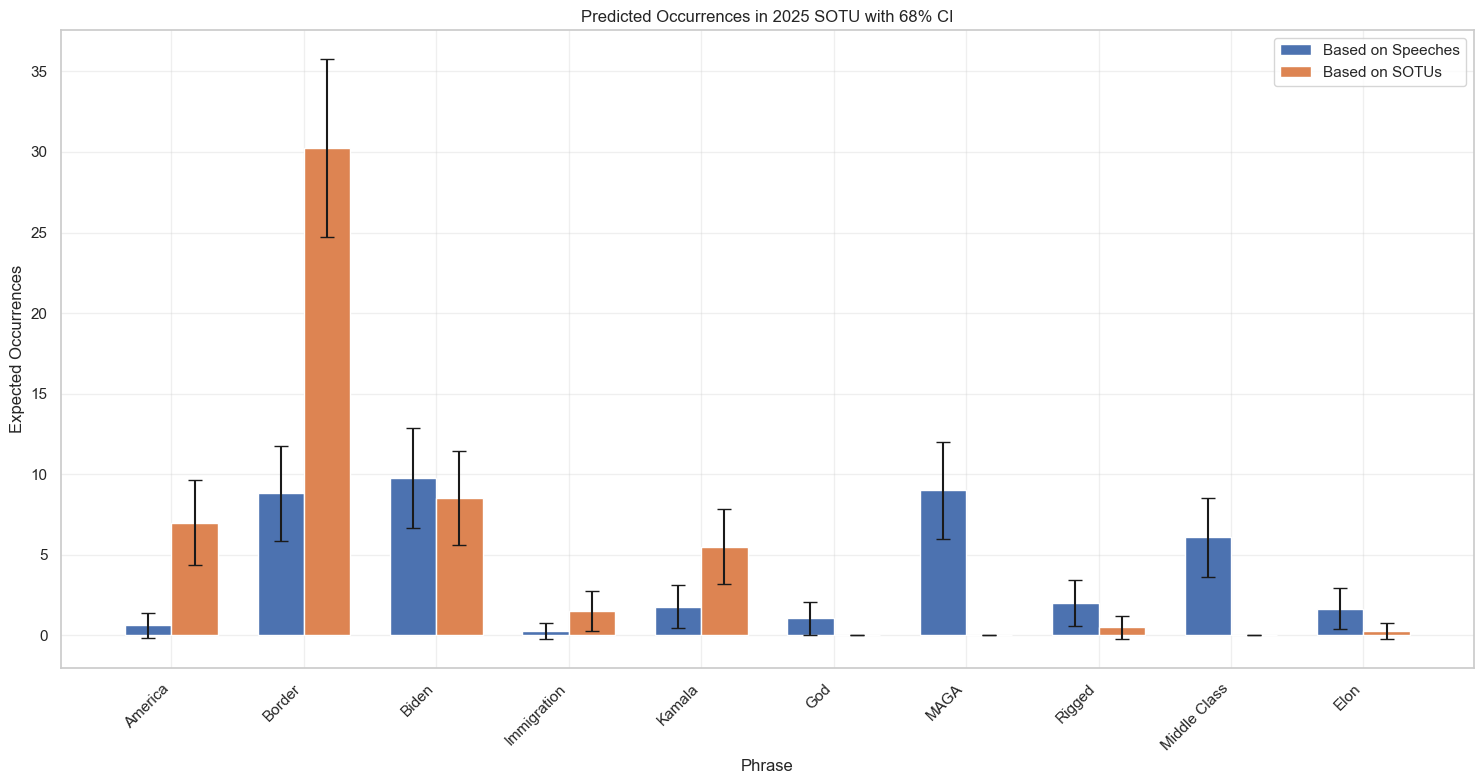

In [7]:
def plot_prediction_comparison(speeches_pred, sotu_pred, top_n=10):
    # Get top N phrases by maximum expected value from either source
    max_expected = pd.concat([
        speeches_pred[['Phrase', 'Expected']].assign(source='Speeches'),
        sotu_pred[['Phrase', 'Expected']].assign(source='SOTU')
    ])
    top_phrases = max_expected.groupby('Phrase')['Expected'].max().nlargest(top_n).index
    
    # Filter for top phrases
    speeches_data = speeches_pred[speeches_pred['Phrase'].isin(top_phrases)]
    sotu_data = sotu_pred[sotu_pred['Phrase'].isin(top_phrases)]
    
    # Create the plot
    plt.figure(figsize=(15, 8))
    
    x = np.arange(len(top_phrases))
    width = 0.35
    
    plt.bar(x - width/2, speeches_data['Expected'], width, label='Based on Speeches',
            yerr=speeches_data['Upper 1σ'] - speeches_data['Expected'], capsize=5)
    plt.bar(x + width/2, sotu_data['Expected'], width, label='Based on SOTUs',
            yerr=sotu_data['Upper 1σ'] - sotu_data['Expected'], capsize=5)
    
    plt.xlabel('Phrase')
    plt.ylabel('Expected Occurrences')
    plt.title('Predicted Occurrences in 2025 SOTU with 68% CI')
    plt.xticks(x, top_phrases, rotation=45, ha='right')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

plot_prediction_comparison(predictions_from_speeches, predictions_from_sotu)